# Multi-Class Classification

In this notebook we will discover how we can go from using a binary classification model to using a multi-class classification model.

Multi-class classification is commonly used to determine what is described in the photo. We will go over how we can build our own classifier see the performance and improve the performance using transfer learning (A powerful way to transfer what another model learned into your own SOTA model)

## Set up datasets

On my github i uploaded datasets of various car models with different damages.

Typical step is to see what sort of data you are working with.
data can be uploaded into a format of either excel or folder directory names.

In [1]:
!wget https://github.com/Mr-Smithy-x/ML-Car-Damage-Classification/raw/main/car_damages_organized_no_csv.zip
!unzip car_damages_organized_no_csv
!rm -rf __MACOSX/
!rm -rf train/bumper_scratch

!mkdir train/bumper
!mkdir test/bumper
!mkdir train/door
!mkdir test/door
!mkdir train/lamp
!mkdir test/lamp

!mv train/bumper_scratch/*.* train/bumper
!mv train/bumper_dent/*.* train/bumper
!mv train/door_scratch/*.* train/door
!mv train/door_dent/*.* train/door
!mv train/tail_lamp/*.* train/lamp
!mv train/head_lamp/*.* train/lamp


!mv test/bumper_scratch/*.* test/bumper
!mv test/bumper_dent/*.* test/bumper
!mv rest/door_scratch/*.* test/door
!mv test/door_dent/*.* test/door
!mv test/tail_lamp/*.* test/lamp
!mv test/head_lamp/*.* test/lamp

!rm -rf train/door_scratch
!rm -rf train/door_dent
!rm -rf train/bumper_scratch
!rm -rf train/bumper_dent
!rm -rf train/tail_lamp
!rm -rf train/head_lamp
!rm -rf test/tail_lamp
!rm -rf test/head_lamp
!rm -rf test/door_scratch
!rm -rf test/door_dent
!rm -rf test/bumper_scratch
!rm -rf test/bumper_dent
!ls

--2021-06-29 21:38:03--  https://github.com/Mr-Smithy-x/ML-Car-Damage-Classification/raw/main/car_damages_organized_no_csv.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Mr-Smithy-x/ML-Car-Damage-Classification/main/car_damages_organized_no_csv.zip [following]
--2021-06-29 21:38:04--  https://raw.githubusercontent.com/Mr-Smithy-x/ML-Car-Damage-Classification/main/car_damages_organized_no_csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10060931 (9.6M) [application/zip]
Saving to: ‘car_damages_organized_no_csv.zip’

car_damages_organiz 100%[===================>]   9.59M  --.-KB/s    i

In [109]:
# Import the required libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import *
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix

import cv2
import os
import itertools


In [110]:
# Read in the instance dataset
def get_image(img):
    imag = image.load_img(img,target_size=(224,224,3))
    imag = image.img_to_array(imag)
    imag = imag/255
    return imag

## Preprocess Image

Right now our data is in a format of  
`[ X [ Y [ R(int:0-255), G(int:0-255) , B(int:0-255) ] ] ]` 

We can actually play around with the classification a bit. if we do not rescale our image aka normalize them, we can see how poorly the model will train without normalizing the data.

### Normalizing the data
What does that mean?

Simply put we are turning

`[ X [ Y [ R(int:0-255), G(int:0-255) , B(int:0-255) ] ] ]` 
into

`[ X [ Y [ R(float:0-1), G(float:0-1) , B(float:0-1) ] ] ]` 

the values 0-255 would be represented as floats ie. from `123, 232, 211` to `0.48, 0.91, 0.83`

In [111]:
train_dir = "/content/train"
test_dir = "/content/test"

train_datagen = ImageDataGenerator(rescale = 1./255, # data normalization
                                  horizontal_flip=True) # Should we flip the photo

train_data = train_datagen.flow_from_directory(
                                        directory=train_dir,
                                        class_mode="categorical", # Because we are doing multiclass-classification
                                        target_size=(224,224),
                                        batch_size=32,
                                        shuffle=True) # Gives better metrics


test_datagen = ImageDataGenerator(rescale = 1./255) # We don't do that on test data, we only normalize

test_data = test_datagen.flow_from_directory(
                                        directory=test_dir,
                                        class_mode="categorical", #categorical
                                        target_size=(224,224),
                                        batch_size=32,
                                        shuffle=True) # magic number

Found 704 images belonging to 4 classes.
Found 162 images belonging to 4 classes.


## Create our model

Our typical procedure when training our model

1. Create the model
2. Compile the model 
3. Fit the model on train and test data
4. Evaluate the model (via confusion matrix)


### Create & View Model

In [112]:
tf.random.set_seed(42)
classifier = Sequential([
    Conv2D(filters=10, kernel_size=2, activation="relu", input_shape=(224,224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 2, activation='relu'),
    MaxPool2D(1),
    Conv2D(10, 2, activation='relu'),
    MaxPool2D(1),
    Flatten(),
    Dense(4, activation='softmax')
])
classifier.summary() # Lets view our model

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 223, 223, 10)      130       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 110, 110, 10)      410       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 109, 109, 10)      410       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 109, 109, 10)      0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 118810)           

### Compile the model
* We're using `Adam()` optimizer
* We want categorical_crossentropy since we're doing multi-class classification 

In [113]:
classifier.compile(optimizer = Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy', 'categorical_accuracy'])

### Fit the model

In [114]:
history = classifier.fit(train_data, 
                epochs = 5, 
                steps_per_epoch = len(train_data),
                validation_data=test_data,
                validation_steps=len(test_data))

Epoch 1/5
22/22 [==============================] - 3s 94ms/step - loss: 3.7335 - accuracy: 0.3168 - categorical_accuracy: 0.3168 - val_loss: 1.5479 - val_accuracy: 0.3148 - val_categorical_accuracy: 0.3148
Epoch 2/5
22/22 [==============================] - 2s 83ms/step - loss: 1.2763 - accuracy: 0.4787 - categorical_accuracy: 0.4787 - val_loss: 1.3222 - val_accuracy: 0.4012 - val_categorical_accuracy: 0.4012
Epoch 3/5
22/22 [==============================] - 2s 82ms/step - loss: 1.1843 - accuracy: 0.5099 - categorical_accuracy: 0.5099 - val_loss: 1.2680 - val_accuracy: 0.3827 - val_categorical_accuracy: 0.3827
Epoch 4/5
22/22 [==============================] - 2s 82ms/step - loss: 1.0345 - accuracy: 0.5724 - categorical_accuracy: 0.5724 - val_loss: 1.1474 - val_accuracy: 0.4568 - val_categorical_accuracy: 0.4568
Epoch 5/5
22/22 [==============================] - 2s 82ms/step - loss: 0.8620 - accuracy: 0.6804 - categorical_accuracy: 0.6804 - val_loss: 1.0806 - val_accuracy: 0.5185 - val

### Lets make a prediction


In [115]:
predictions = classifier.predict(test_data)
predictions

array([[2.93484390e-01, 4.36746210e-01, 2.06584949e-03, 2.67703563e-01],
       [1.09573044e-01, 7.63655961e-01, 1.43820909e-03, 1.25332788e-01],
       [2.33076453e-01, 5.43543279e-01, 2.81851627e-02, 1.95195124e-01],
       [4.59763408e-01, 3.12627047e-01, 2.34503597e-02, 2.04159141e-01],
       [6.54299796e-01, 3.28968614e-01, 7.68976053e-03, 9.04177502e-03],
       [7.87528381e-02, 1.46144047e-01, 7.19368935e-01, 5.57341799e-02],
       [4.13753651e-02, 2.06010044e-01, 4.71228182e-01, 2.81386435e-01],
       [2.21008435e-01, 7.18406260e-01, 3.36362980e-02, 2.69490220e-02],
       [2.75127053e-01, 6.84356868e-01, 1.97727531e-02, 2.07432862e-02],
       [2.77822584e-01, 4.01052386e-01, 2.06664979e-01, 1.14459999e-01],
       [4.12722349e-01, 2.83803433e-01, 1.00063272e-01, 2.03410983e-01],
       [5.39235115e-01, 2.07234874e-01, 1.87167332e-01, 6.63626716e-02],
       [2.59206127e-02, 2.58659840e-01, 1.31479234e-01, 5.83940327e-01],
       [2.59729415e-01, 3.06583762e-01, 3.60074230e

### Evaluate the model

In [116]:
classes = train_data.class_indices
inverted_classes = dict(map(reversed, classes.items()))
print(f"Classes: {classes}")
print(f"Inverted Classes: {inverted_classes}")

Classes: {'bumper': 0, 'door': 1, 'glass_shatter': 2, 'lamp': 3}
Inverted Classes: {0: 'bumper', 1: 'door', 2: 'glass_shatter', 3: 'lamp'}


Lets make sure that our predictions are in the same shape as our y_true classes

In [117]:
import pandas as pd
y_test = test_data.classes
y_pred = np.argmax(predictions, axis=1)
y_test.shape, y_pred.shape # They are the same

((162,), (162,))

### Confusion Matrix

How well is our model learning?

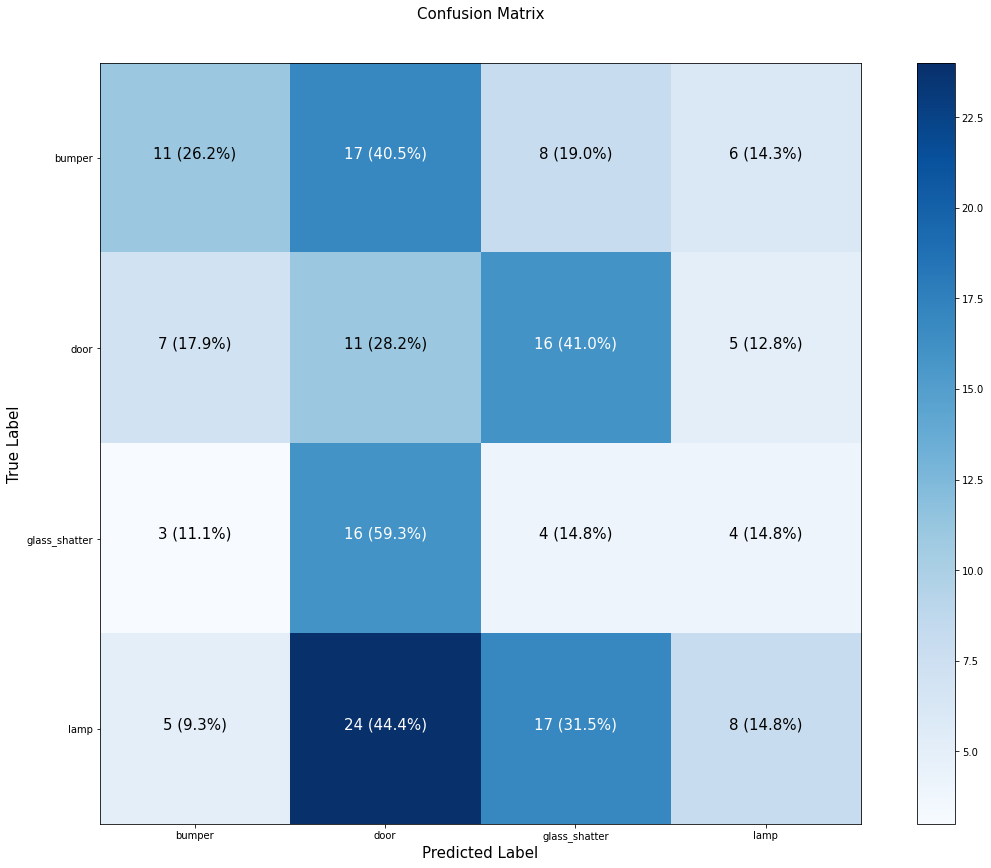

In [118]:
# Create a confusion matrix

# Note: the confusion matrix code we're about to write is a remix of sci-kit-learns's plot confusion matrix function
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10,10), text_size=15):
  #print(y_true.image_shape, y_pred.shape)
  cm = confusion_matrix(y_true, y_pred)
  cm_normalize = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize our confusion matrix
  n_classes = cm.shape[0]

  #Let's prettify it
  fig, ax = plt.subplots(figsize=figsize)

  #Creat a matrix plot
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  #Set labels to be classes
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  #Label the axes
  ax.set(
      title="Confusion Matrix", 
      xlabel="Predicted Label", 
      ylabel="True Label", 
      xticks=np.arange(n_classes), 
      yticks=np.arange(n_classes), 
      xticklabels=labels, 
      yticklabels=labels)

  #Set axes label to bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  #Adjust label size
  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)

  #Set threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.
  
  #plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i,j]} ({cm_normalize[i,j] *100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size)
    
make_confusion_matrix(y_test, y_pred, classes=classes, figsize=(20,14))

Our data + confusion matrix metrics
`loss: 0.6409 - categorical_accuracy: 0.7614 - val_loss: 1.1547 - val_categorical_accuracy: 0.5926`

* Good categorical accuracy
* Poor loss (model is getting more than half the results wrong)
* Val Loss is not good either 115% loss
* Val Category (Seems that when giving the model test images, it guesses them right half the time, this is not good either)

Our model looks to be underfitting.

## Improving our metrics using Transfer Learning

Since our model isn't learning our data properly what may be the issue? and how can we fix it
* The dataset isn't doing too well when training, we can supply more data to it
* We can try playing with the epochs learning rate with the model or even explore other optimizers. RMSProp, Adam are good alternatives
* We could try **Transfer Learning** to improve our metrics

In [119]:
# Create Tensorboard callback (functionize because we need to create a new one for each)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

For this model we will apply Transfer Learning using google's ResNetV2_50 

In [120]:
# LEts compare the following two model
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [121]:
#Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

### Create the Model

In [122]:
IMAGE_SHAPE = (224, 224)
# Let's make a create model function to create a model from a URL
def create_model(model_url, num_classes=10, name="feature_extraction_layer"):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras Layer
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable=False, 
                                           name=name,
                                           input_shape=IMAGE_SHAPE+(3,)) # feeze the already learned patterns

  # Create our own model
  model = tf.keras.Sequential([
     feature_extractor_layer,
     layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model


In [123]:
tf.random.set_seed(42)
resnet_model = create_model(resnet_url,  num_classes=train_data.num_classes)

### View our model summary

We can see that there are 23.5mil different params for googles feature extraction model, which wont be trained on but will be trained on our dense layers when outputing different categorical probabilities.

In [124]:
resnet_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 4)                 8196      
Total params: 23,572,996
Trainable params: 8,196
Non-trainable params: 23,564,800
_________________________________________________________________


### Compile our Transfer Learning Model

In [125]:
# Compile our resnet model
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, epsilon=1e-07,  rho=0.9),
                     metrics=["accuracy", "categorical_accuracy"])

### Fit The Model

In [126]:
early = create_tensorboard_callback("/content/logs", "resnet")
history_resnet = resnet_model.fit(train_data, 
                 epochs=5, 
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=early)

Saving TensorBoard log files to: /content/logs/resnet/20210629-060136
Epoch 1/5
22/22 [==============================] - 9s 201ms/step - loss: 0.8593 - accuracy: 0.6761 - categorical_accuracy: 0.6761 - val_loss: 0.8286 - val_accuracy: 0.7160 - val_categorical_accuracy: 0.7160
Epoch 2/5
22/22 [==============================] - 2s 112ms/step - loss: 0.3794 - accuracy: 0.8778 - categorical_accuracy: 0.8778 - val_loss: 0.5742 - val_accuracy: 0.8025 - val_categorical_accuracy: 0.8025
Epoch 3/5
22/22 [==============================] - 2s 103ms/step - loss: 0.2577 - accuracy: 0.9276 - categorical_accuracy: 0.9276 - val_loss: 0.5602 - val_accuracy: 0.7901 - val_categorical_accuracy: 0.7901
Epoch 4/5
22/22 [==============================] - 2s 102ms/step - loss: 0.1727 - accuracy: 0.9517 - categorical_accuracy: 0.9517 - val_loss: 0.5923 - val_accuracy: 0.7840 - val_categorical_accuracy: 0.7840
Epoch 5/5
22/22 [==============================] - 2s 101ms/step - loss: 0.1389 - accuracy: 0.9645 - c

### Make a prediction

In [127]:
resnet_predictions = resnet_model.predict(test_data)

In [128]:
y_resnet_pred = np.argmax(resnet_predictions, axis=1)

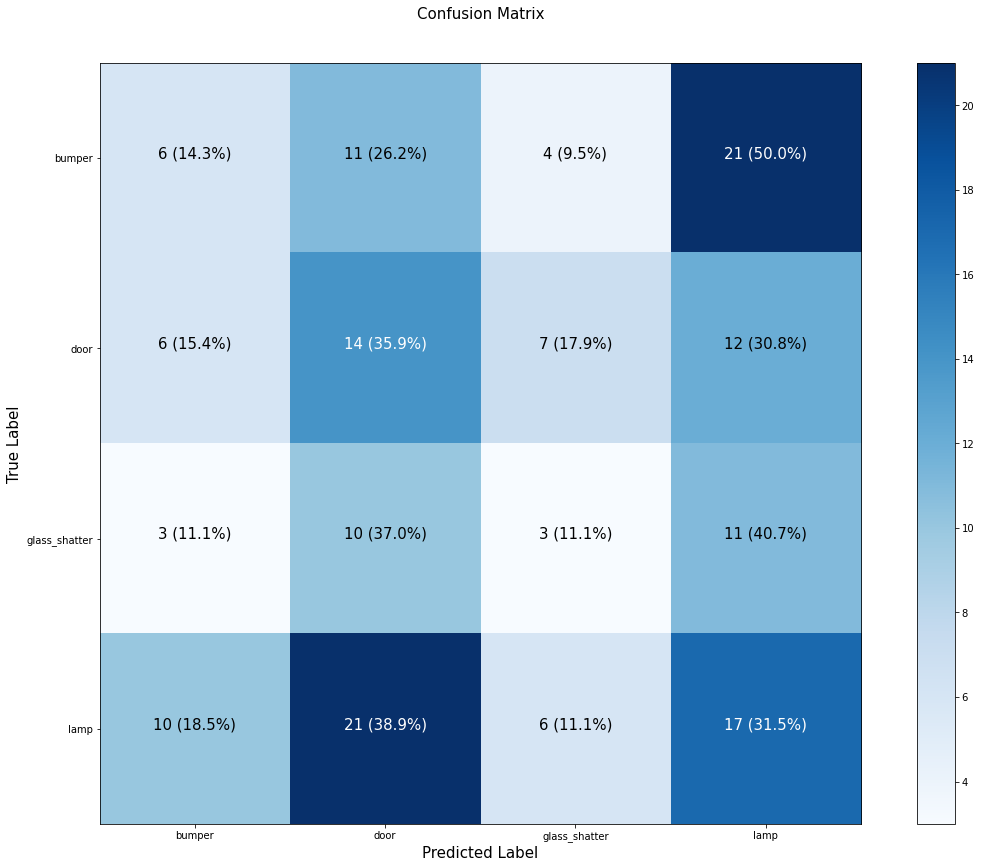

In [129]:
make_confusion_matrix(y_test, y_resnet_pred, classes, figsize=(20,14))

### How is our model fairing?
`loss: 0.1152 - categorical_accuracy: 0.9744 - val_loss: 0.6742 - val_categorical_accuracy: 0.7593`

Metrics are certainly better
* Loss: Low loss, that is pretty good
* Cat Accuracy: Amazing metrics, seems like our model training is pretty accurate
* Val loss: This could be improved, val_loss is a bit too high compare to loss
* Val Cat Accuracy: This could also be improved 3/4 images will have a correct output

Our model is doing better but certainly could be improved. We want to aim for a high accuracy and a low loss.

### View Loss Curves

A good way to see how our model is performing is also by plotting the loss curves

In [130]:
# Lets create function to plot loss curves

#Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it
def plot_loss_curves(history):
  """
  Return seperate loss curves for training and validation metrics

  Args:
    history: TensorFlow History object

  Returns:
    Plots of training validation loss and accuracy metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  
  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label="Training Loss")
  plt.plot(epochs, val_loss, label="Val Loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="Training Accuracy")
  plt.plot(epochs, val_accuracy, label="Val Accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()
  

ResnetV2 50 Metrics


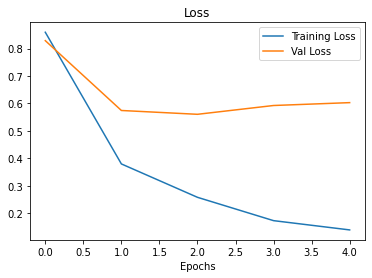

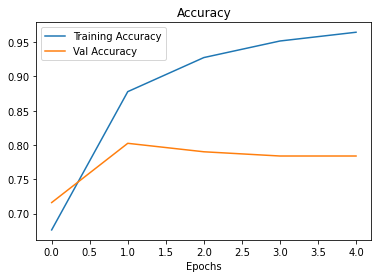

In [131]:
print("ResnetV2 50 Metrics")
plot_loss_curves(history_resnet)

Old Model History


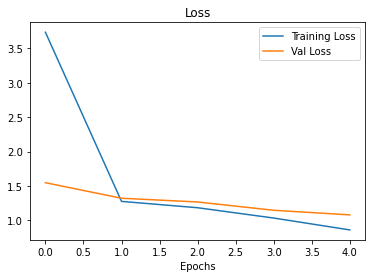

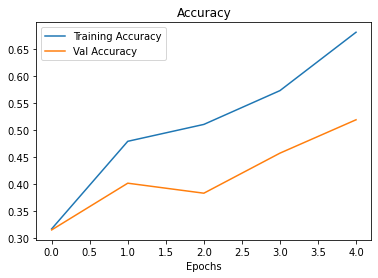

In [132]:

print("Old Model History")
plot_loss_curves(history)



### Random Prediction

In [133]:
!wget https://c8.alamy.com/comp/R801MR/damaged-passenger-door-of-black-car-R801MR.jpg
!wget https://andymohrcol.wpengine.com/wp-content/uploads/2020/08/bumper-damage.png
!wget https://thumbs.dreamstime.com/z/broken-headlamp-black-car-38099173.jpg
!mv damaged-passenger-door-of-black-car-R801MR.jpg door.jpg
!mv bumper-damage.png bumper.png
!mv broken-headlamp-black-car-38099173.jpg lamp.jpg
from PIL import Image

image = Image.open("bumper.png")
image_rgb = image.convert('RGB')
image_rgb.save('bumper.jpg')
!rm bumper.png

--2021-06-29 06:01:57--  https://c8.alamy.com/comp/R801MR/damaged-passenger-door-of-black-car-R801MR.jpg
Resolving c8.alamy.com (c8.alamy.com)... 52.8.113.156, 54.241.197.179, 52.52.13.246, ...
Connecting to c8.alamy.com (c8.alamy.com)|52.8.113.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘damaged-passenger-door-of-black-car-R801MR.jpg’

damaged-passenger-d     [ <=>                ] 194.17K  --.-KB/s    in 0.05s   

Last-modified header invalid -- time-stamp ignored.
2021-06-29 06:01:57 (4.13 MB/s) - ‘damaged-passenger-door-of-black-car-R801MR.jpg’ saved [198835]

--2021-06-29 06:01:57--  https://andymohrcol.wpengine.com/wp-content/uploads/2020/08/bumper-damage.png
Resolving andymohrcol.wpengine.com (andymohrcol.wpengine.com)... 35.184.1.244
Connecting to andymohrcol.wpengine.com (andymohrcol.wpengine.com)|35.184.1.244|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://w

In [134]:
# View out example image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Create a function to import an image and resize it to be able to use with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads and image from filename, 
  turns it into a tensor and respaes it to img_shape, img_shape, color_channels
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decod eht eread file into a tensor
  img = tf.image.decode_image(img)
  #Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [135]:
# Only works with binary
def pred_and_plot(model, filename, class_name):
  """
  Imports an image loacted at filename, makes a predecition with model and plots the image with the predicted class as the title.
  """

  #import the target image and preprocess it
  img = load_and_prep_image(filename)
  if img.shape == (224,224, 4):
    print(img.shape)
  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class

  # Add in logic for multiclass and get pred_class name
  if len(pred[0]) > 1:
    max = np.argmax(pred[0])
    pred_class = class_name[max]
  else:
    # Get the predicted class
    pred_class = class_name[int(tf.round(pred))]

  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)
  return pred_class

'door'

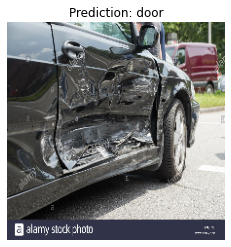

In [136]:
pred_and_plot(resnet_model, 'door.jpg', class_name=inverted_classes)

Wrong prediction

'glass_shatter'

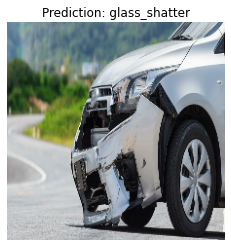

In [137]:
pred_and_plot(resnet_model, 'bumper.jpg', class_name=inverted_classes)

'lamp'

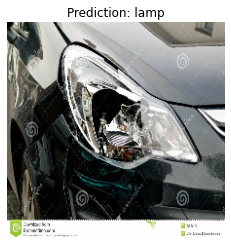

In [138]:
pred_and_plot(resnet_model, 'lamp.jpg', class_name=inverted_classes)

In [139]:
door = load_and_prep_image("door.jpg")
pred = resnet_model.predict(tf.expand_dims(door, axis=0))
pred

array([[7.7463971e-03, 9.6842247e-01, 7.5480249e-04, 2.3076354e-02]],
      dtype=float32)

In [155]:
#Which one?
index = np.argmax(pred, axis=1)
index, inverted_classes[index[0]]

(array([1]), 'door')

Get the index which has the predicted result

## What about efficient net?

In [145]:
tf.random.set_seed(42)
b0 = create_model(efficientnet_url,  num_classes=train_data.num_classes)
b0.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
b0.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 4)                 5124      
Total params: 4,054,688
Trainable params: 5,124
Non-trainable params: 4,049,564
_________________________________________________________________


In [146]:
callback = create_tensorboard_callback("/content/logs/tensorflow_hub/", "b0")
b0_history = b0.fit(train_data, epochs=5, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=len(test_data), callbacks=callback)

Saving TensorBoard log files to: /content/logs/tensorflow_hub//b0/20210629-061845
Epoch 1/5
22/22 [==============================] - 15s 252ms/step - loss: 1.0406 - accuracy: 0.5653 - val_loss: 0.8694 - val_accuracy: 0.6543
Epoch 2/5
22/22 [==============================] - 2s 94ms/step - loss: 0.5671 - accuracy: 0.8366 - val_loss: 0.6272 - val_accuracy: 0.7963
Epoch 3/5
22/22 [==============================] - 2s 93ms/step - loss: 0.3936 - accuracy: 0.8963 - val_loss: 0.5463 - val_accuracy: 0.8272
Epoch 4/5
22/22 [==============================] - 2s 95ms/step - loss: 0.3143 - accuracy: 0.9276 - val_loss: 0.5096 - val_accuracy: 0.8333
Epoch 5/5
22/22 [==============================] - 2s 97ms/step - loss: 0.2635 - accuracy: 0.9403 - val_loss: 0.4765 - val_accuracy: 0.8395


### Evaluate

Plot b0 Model History


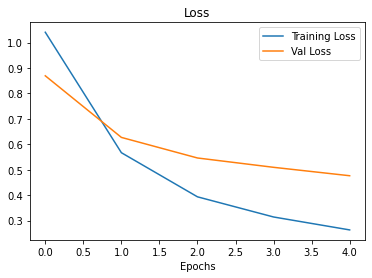

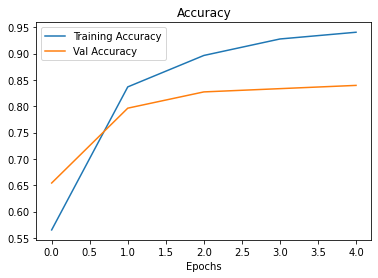

In [150]:
print("Plot b0 Model History")
plot_loss_curves(b0_history)

### Predict

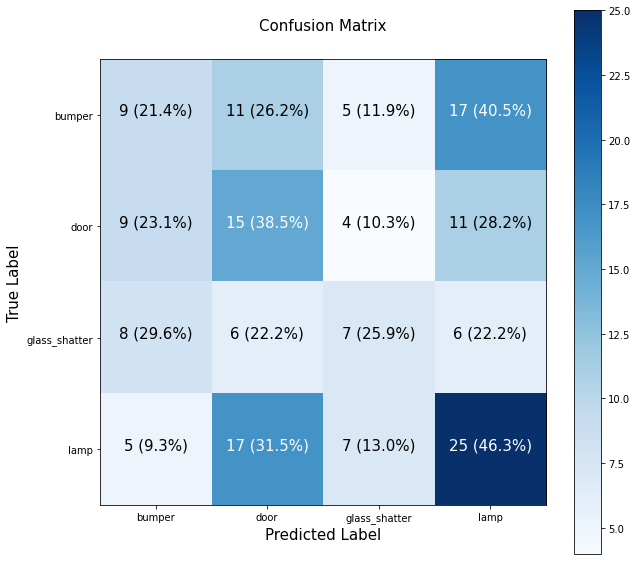

In [153]:
b0_pred = b0.predict(test_data)
y_b0_pred = np.argmax(b0_pred, axis=1)
make_confusion_matrix(y_test, y_b0_pred, classes)

In [149]:
# Lets set our random seet
tf.random.set_seed(42)

# Create model
model = Sequential([
   Flatten(input_shape=(224,224, 3))
])

# Compile model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["acc"])



#create the learning rate callback
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))

#Fit the model
#X_train_normalized.shape
history = model.fit(X_train_normalized, y_train, epochs=5, validation_data=(X_test_normalized, y_test), batch_size=32)# , callbacks=[lr_scheduler]

NameError: ignored

In [ ]:
lrs = 1e-3 * (10**(tf.range(20)/20))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.title("Finding the ideal learning rate")